Show the ROC curves for the various classifiers on frb's

In [1]:
from __future__ import division
%matplotlib inline 
from matplotlib import pyplot as plt
import numpy as np
import sys
sys.path.append("src")

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from IsolationClassifier import IsolationTreeClassifier, IsolationRatioClassifier
from pca_frb import PCA_Classifier

from sklearn.metrics import roc_curve, roc_auc_score 
from sklearn.model_selection import KFold, StratifiedKFold 

#In a slightly hacky way, add a 'predict_proba' method to the IsolationTree classes
#it doesn't return a probability, but it allows us to call the same method on all the classifiers 

def decision_function(self, X):
    return self.predict_proba(X)[:,1] #prob scores for class 1 

DecisionTreeClassifier.decision_function = decision_function 
MLPClassifier.decision_function = decision_function
GaussianNB.decision_function = decision_function
RandomForestClassifier.decision_function = decision_function
AdaBoostClassifier.decision_function = decision_function



classifiers = []
classifiers.append(("PCA Classifier", PCA_Classifier()))
classifiers.append(("CART_tree", DecisionTreeClassifier()))
classifiers.append(("MLP", Pipeline([('scaler', StandardScaler()), ('mlp',MLPClassifier())])))
classifiers.append(("Naive_Bayes", GaussianNB()))
#classifiers.append(("SVM", Pipeline([('scaler', StandardScaler()),
#                                     ('svc',SVC(class_weight ='balanced'))])))
#classifiers.append(("Linear SVM", Pipeline([('scaler', StandardScaler()),
 #                                           ('svc',LinearSVC(class_weight ='balanced'))])))
classifiers.append(("Random_Forest", RandomForestClassifier()))
classifiers.append(("AdaBoost", AdaBoostClassifier()))
classifiers.append(("IsolationForestClassifier", IsolationTreeClassifier(max_samples=8000)))
classifiers.append(("IsolationRatioClassifier", IsolationRatioClassifier(max_samples=8000)))


In [2]:
with open("frb_datasets/w_snr_dm_nn_score.dat") as f:
    data_file = [[float(field) for field in line.strip().split(' ')] for line in f]
    
all_data = np.array(data_file, dtype=np.float32)

#remove all frbs from the dataset: we only want to train the encoder on noise, in order to detect outliers 

X = all_data[:,:-1] #remove the class label from the training data 
Y = all_data[:,-1].astype(np.int) #class labels
    

In [3]:
from scipy import interp 

def mean_roc_curve(clf, X, Y, axes, n_folds = 5, color = 'k', legend = "", stratified = True):
    """
    See the example at 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
    """
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    cv = StratifiedKFold(n_splits = n_folds, shuffle = True) if stratified else KFold(n_splits = n_folds, shuffle = True)
    roc_scores = np.zeros(n_folds)
    roc_curves = []
    i = 0
    for train_inds, test_inds in cv.split(X,Y):
        train_x = X[train_inds]
        train_y = Y[train_inds]
        test_x  = X[test_inds]
        test_y  = Y[test_inds]
        
        
        #print class ratio 
        
        clf.fit(train_x, train_y)
        scores = clf.decision_function(test_x)
        fpr, tpr, thresholds = roc_curve(test_y, scores, pos_label = 1)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        roc_scores[i] = roc_auc_score(test_y, scores)
        i+=1
        
    mean_tpr /= n_folds     
    mean_tpr[0] = 0.0
    mean_tpr[-1] = 1.0
    axes.plot(mean_fpr, mean_tpr, color = color, label = legend)
    return roc_scores.mean(), roc_scores.std(ddof = 1)
        

    
    

PCA Classifier ROC Score: 0.923127869044 +/- 0.0652394062968
CART_tree ROC Score: 0.849248707539 +/- 0.0709476540891
MLP ROC Score: 0.997517321756 +/- 0.00248087630949
Naive_Bayes ROC Score: 0.986785337693 +/- 0.01380321118
Random_Forest ROC Score: 0.970294626886 +/- 0.0500649241149
AdaBoost ROC Score: 0.995660156943 +/- 0.00459140299801
IsolationForestClassifier ROC Score: 0.973588983601 +/- 0.0156913421836
IsolationRatioClassifier ROC Score: 0.974978425945 +/- 0.0249509242952


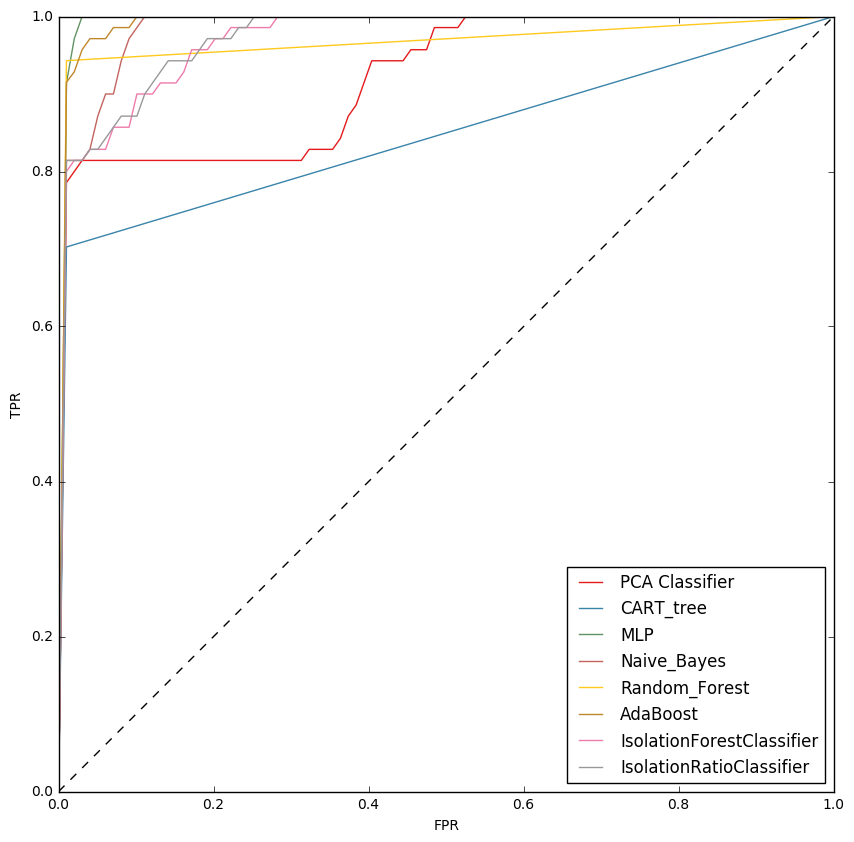

In [4]:
plt.rcParams['figure.figsize'] = 10,10

from matplotlib.cm import get_cmap
f, ax = plt.subplots(1)

cmap = get_cmap('Set1')
colors = [cmap(i) for i in np.linspace(0,1, len(classifiers))]

for (name, clf), col  in zip(classifiers, colors): 
    rscore_mean, rscore_std = mean_roc_curve(clf, X, Y, ax,n_folds = 10, color = col, legend = name)
    print "{} ROC Score: {} +/- {}".format(name, rscore_mean, rscore_std)

#plot the guessing line 
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle = '--', color = 'k')

#add the line for just using an SNR cutoff 
snr = X[:,1]
fpr, tpr, thresholds = roc_curve(Y, snr, pos_label = 1)
ax.plot(fpr,tpr, linestyle = '--', color = 'blue', label = 'SNR')
ax.legend(loc = 'lower right')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')

This compares a set of supervised classifiers with the semi-supervised approach in stratified cross validation by comparing their Reciever-Operating Characteristic curves (the true positive rate plotted against the false positive rate). The dotted line indicated equal true and false positive rates (which would be achieved by a classifier that guessed the labels randomly. 
This shows that the semi-supervised approach outperforms a simple decision tree and (perhaps suprisingly) random forest, normally a strong classifier, but is outperformed by naive bayes once TPR's above around 95% are expected, and is outperformed in general by adaboost and mlp. 
That supervised approaches outperform semi-supervised is probably to be expected: the advantage of the isolation forest is that it does not in fact require any positives during training. That it can still achieve similar classification performance to a fully supervised approach (which requires training data to avoid overfitting) is pretty good really.
It does indicate that in practice it might be desirable to gradually transition to a more supervised approach as more training data becomes avaliable. 



CART_tree ROC Score: 0.864302884478 +/- 0.115396987101
MLP ROC Score: 0.997814832573 +/- 0.00180363140297
Naive_Bayes ROC Score: 0.988377312587 +/- 0.0108937949259
Random_Forest ROC Score: 0.948573851357 +/- 0.0546614362608
AdaBoost ROC Score: 0.991375969254 +/- 0.0133811691095
IsolationForestClassifier ROC Score: 0.974351884938 +/- 0.0319832001695
IsolationRatioClassifier ROC Score: 0.97123824053 +/- 0.0231413659371


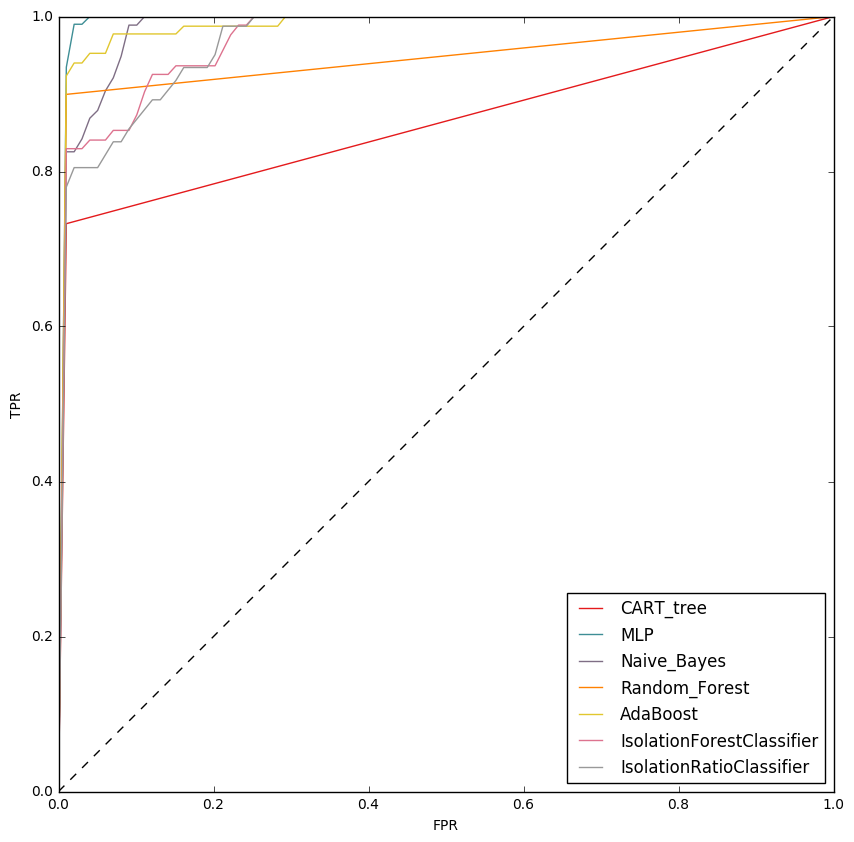

In [8]:
f, ax = plt.subplots(1)
for (name, clf), col  in zip(classifiers, colors): 
    rscore_mean, rscore_std = mean_roc_curve(clf, X, Y, ax,n_folds = 10, color = col, legend = name, stratified = False)
    print "{} ROC Score: {} +/- {}".format(name, rscore_mean, rscore_std)

#plot the guessing line 
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle = '--', color = 'k')
ax.legend(loc = 'lower right')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')

Not doing stratifed cross val doesn't hurt the other classifiers as much as I expected: I suppose that the FRB rate is so low it is effectively the same. 
